In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load cleaned books
books_df = pd.read_csv("C:/Users/User/Downloads/FYPBookRecommendation/Books_20000.csv")
"C:\Users\User\Downloads\\Books_20000.csv"
# Display columns and sample
print(books_df.columns)
print(books_df[['ISBN', 'Book-Title', 'Book-Author']].head())


Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
         ISBN                                         Book-Title  \
0  0679764275                                         The F Word   
1  3257228589                                      Davids Rache.   
2  0812577647                                          Sky Knife   
3  0156372118                              The Groves of Academe   
4  0590470485  Karen's Lucky Penny (Baby-Sitters Little Siste...   

              Book-Author  
0        Jesse Sheidlower  
1  Hans Werner Kettenbach  
2           Marella Sands  
3           Mary McCarthy  
4           Ann M. Martin  


In [56]:
# Fill missing values
books_df['Book-Title'] = books_df['Book-Title'].fillna('')
books_df['Book-Author'] = books_df['Book-Author'].fillna('')
books_df['Publisher'] = books_df['Publisher'].fillna('')

# Combine features (Title + Author + Publisher)
books_df['features'] = (
    books_df['Book-Title'] + ' ' + 
    books_df['Book-Author'] + ' ' + 
    books_df['Publisher']
)

# Lowercase
books_df['features'] = books_df['features'].str.lower()

print(books_df[['Book-Title', 'features']].head())


                                          Book-Title  \
0                                         The F Word   
1                                      Davids Rache.   
2                                          Sky Knife   
3                              The Groves of Academe   
4  Karen's Lucky Penny (Baby-Sitters Little Siste...   

                                            features  
0  the f word jesse sheidlower random house refer...  
1  davids rache. hans werner kettenbach diogenes ...  
2                  sky knife marella sands tor books  
3       the groves of academe mary mccarthy harcourt  
4  karen's lucky penny (baby-sitters little siste...  


In [57]:
# Initialize TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit-transform
tfidf_matrix = tfidf.fit_transform(books_df['features'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (20000, 5000)


In [58]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Cosine Similarity Matrix shape: {cosine_sim.shape}")


Cosine Similarity Matrix shape: (20000, 20000)


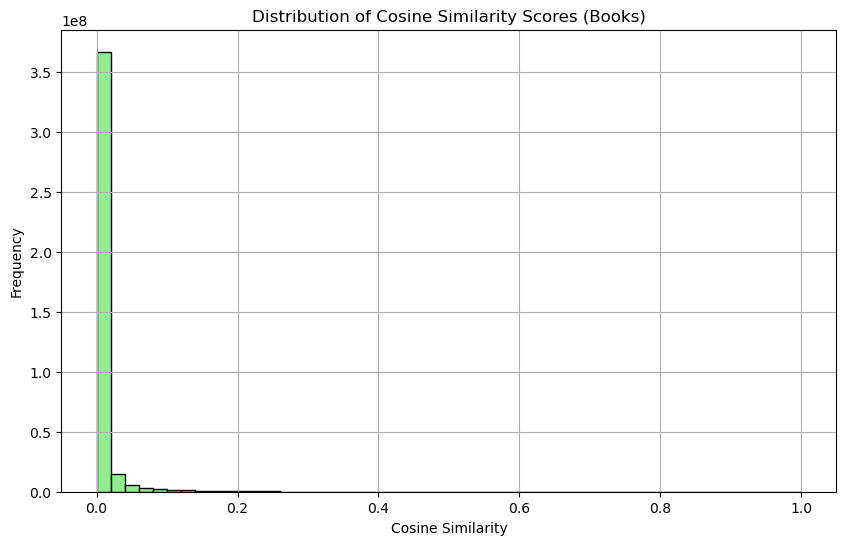

In [59]:
plt.figure(figsize=(10, 6))
plt.hist(cosine_sim.flatten(), bins=50, color='lightgreen', edgecolor='black')
plt.title("Distribution of Cosine Similarity Scores (Books)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [60]:
# Create name-to-indices mapping
name_to_indices = pd.Series(books_df.index, index=books_df['Book-Title'].str.lower()).drop_duplicates()

def recommend_books_by_query(query_name, top_k=5):
    query_name = query_name.lower()
    
    # Find all book indices that contain the query
    matching_indices = [idx for name, idx in name_to_indices.items() if query_name in name]
    
    if not matching_indices:
        print(f"No books found matching '{query_name}'.")
        return pd.DataFrame(columns=['ISBN', 'Book-Title', 'Book-Author', 'Publisher'])
    
    # Combine the vectors of all matching books
    combined_vector = np.mean(tfidf_matrix[matching_indices].toarray(), axis=0).reshape(1, -1)
    
    # Compute cosine similarity between combined vector and all books
    sim_scores = cosine_similarity(combined_vector, tfidf_matrix).flatten()
    
    # Sort and get top_k indices
    top_indices = sim_scores.argsort()[::-1][:top_k]
    
    # Return recommended books
    return books_df.iloc[top_indices][['ISBN', 'Book-Title', 'Book-Author', 'Publisher']]


In [61]:
print("="*70)
print("Recommendations for 'Harry Potter':")
print("="*70)
print(recommend_books_by_query("Harry Potter", top_k=5))

print("\n" + "="*70)
print("Recommendations for 'Lord of the Rings':")
print("="*70)
print(recommend_books_by_query("Lord of the Rings", top_k=5))

print("\n" + "="*70)
print("Recommendations for 'Stephen King':")
print("="*70)
print(recommend_books_by_query("Stephen King", top_k=5))


Recommendations for 'Harry Potter':
            ISBN                                         Book-Title  \
9638  043955490X  Harry Potter and the Goblet of Fire (Harry Pot...   
5287  0439554896  Harry Potter and the Chamber of Secrets (Harry...   
8188  0613206339  Harry Potter and the Sorcerer's Stone (Harry P...   
2770  043936213x     Harry Potter and the Sorcerer's Stone (Book 1)   
5199  043935806X  Harry Potter and the Order of the Phoenix (Boo...   

        Book-Author               Publisher  
9638  J. K. Rowling  Arthur A. Levine Books  
5287  J. K. Rowling  Arthur A. Levine Books  
8188  J. K. Rowling         Sagebrush Bound  
2770  J. K. Rowling              Scholastic  
5199  J. K. Rowling              Scholastic  

Recommendations for 'Lord of the Rings':
             ISBN                                         Book-Title  \
13198  0618260285  The Return of the King (The Lord of the Rings,...   
5434   0618002243  The Return of the King (The Lord of The Rings,...   
136

In [62]:
def evaluate_book_recommendations_features(test_books, books_df, similarity_matrix, k_values=[5, 10, 15, 20]):
    """
    Evaluate book recommendations using feature overlap.
    Returns precision and recall for each k.
    """
    precision_scores = []
    recall_scores = []

    for k in k_values:
        k_precision = []
        k_recall = []

        for book_name in test_books:
            # Get top-k recommendations
            recommended_names = recommend_books_by_query(book_name, top_k=k)['Book-Title']
            recommendations = books_df.loc[books_df['Book-Title'].isin(recommended_names), ['Book-Title','features']]

            # Ground truth features of the test book
            test_data = books_df.loc[books_df['Book-Title'].str.lower() == book_name.lower()]
            if test_data.empty:
                continue

            true_features = set(test_data['features'].values[0].split())  # Split words in features
            total_relevance = 0

            for _, row in recommendations.iterrows():
                rec_features = set(str(row['features']).split())
                overlap = len(true_features & rec_features) / len(true_features) if len(true_features) > 0 else 0
                total_relevance += overlap

            # Compute precision and recall
            precision = total_relevance / k
            recall = total_relevance  # sum of overlaps
            k_precision.append(precision)
            k_recall.append(recall)

        precision_scores.append(np.mean(k_precision))
        recall_scores.append(np.mean(k_recall))

    return k_values, precision_scores, recall_scores


In [63]:
np.random.seed(42)
test_books = books_df['Book-Title'].sample(10, random_state=42).tolist()
k_values, precision_scores, recall_scores = evaluate_book_recommendations_features(test_books, books_df, cosine_sim)

print("\nEvaluation Results:")
for k, precision, recall in zip(k_values, precision_scores, recall_scores):
    print(f"k={k}: Precision={precision:.4f}, Recall={recall:.4f}")



Evaluation Results:
k=5: Precision=0.4083, Recall=2.0413
k=10: Precision=0.2997, Recall=2.9973
k=15: Precision=0.2673, Recall=4.0089
k=20: Precision=0.2483, Recall=4.9650


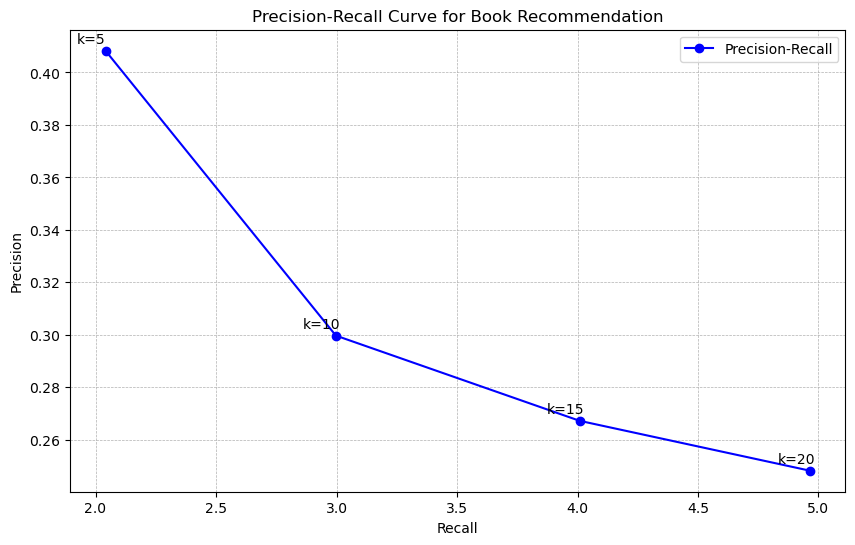

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(recall_scores, precision_scores, marker='o', linestyle='-', color='b', label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Book Recommendation")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate the points with k values
for i, k in enumerate(k_values):
    plt.annotate(f"k={k}", (recall_scores[i], precision_scores[i]), textcoords="offset points", xytext=(-10,5), ha='center')

plt.legend()
plt.show()

In [65]:
ngram_ranges = [(1,1), (1,2)]
max_dfs = [0.8, 1.0]
min_dfs = [1, 2]
max_features_list = [3000, 5000]

# Random test books
np.random.seed(42)
test_books = books_df['Book-Title'].sample(10, random_state=42).tolist()

best_precision = 0
best_config = {}
results = []

for ngram in ngram_ranges:
    for max_df in max_dfs:
        for min_df in min_dfs:
            for max_feat in max_features_list:
                print(f"\nTesting: ngram={ngram}, max_df={max_df}, min_df={min_df}, max_features={max_feat}")
                
                # Build TF-IDF on features
                tfidf = TfidfVectorizer(
                    stop_words='english',
                    ngram_range=ngram,
                    max_df=max_df,
                    min_df=min_df,
                    max_features=max_feat
                )
                
                tfidf_matrix = tfidf.fit_transform(books_df['features'].fillna(''))
                
                # Compute cosine similarity
                cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
                
                # Evaluate
                k_values, precision_scores, recall_scores = evaluate_book_recommendations_features(test_books, books_df, cosine_sim)
                avg_precision = np.mean(precision_scores)
                
                # Print results
                for k, p, r in zip(k_values, precision_scores, recall_scores):
                    print(f"  k={k}: Precision={p:.4f}, Recall={r:.4f}")
                print(f"  → Avg Precision: {avg_precision:.4f}")
                
                results.append({
                    'config': (ngram, max_df, min_df, max_feat),
                    'precision': precision_scores,
                    'recall': recall_scores
                })
                
                if avg_precision > best_precision:
                    best_precision = avg_precision
                    best_config = {'ngram': ngram, 'max_df': max_df, 'min_df': min_df, 'max_features': max_feat}
                    best_scores = (precision_scores, recall_scores)
                    best_k_values = k_values
                    best_tfidf_matrix = tfidf_matrix
                    best_cosine_sim = cosine_sim

# Print best config
print("\nBest Configuration:")
for key, val in best_config.items():
    print(f"{key}: {val}")
print(f"Average Precision: {best_precision:.4f}")




Testing: ngram=(1, 1), max_df=0.8, min_df=1, max_features=3000
  k=5: Precision=0.3997, Recall=1.9983
  k=10: Precision=0.3071, Recall=3.0708
  k=15: Precision=0.2758, Recall=4.1369
  k=20: Precision=0.2554, Recall=5.1084
  → Avg Precision: 0.3095

Testing: ngram=(1, 1), max_df=0.8, min_df=1, max_features=5000
  k=5: Precision=0.4083, Recall=2.0413
  k=10: Precision=0.2997, Recall=2.9973
  k=15: Precision=0.2673, Recall=4.0089
  k=20: Precision=0.2483, Recall=4.9650
  → Avg Precision: 0.3059

Testing: ngram=(1, 1), max_df=0.8, min_df=2, max_features=3000
  k=5: Precision=0.4008, Recall=2.0042
  k=10: Precision=0.3075, Recall=3.0745
  k=15: Precision=0.2770, Recall=4.1557
  k=20: Precision=0.2570, Recall=5.1393
  → Avg Precision: 0.3106

Testing: ngram=(1, 1), max_df=0.8, min_df=2, max_features=5000
  k=5: Precision=0.4106, Recall=2.0529
  k=10: Precision=0.2990, Recall=2.9898
  k=15: Precision=0.2704, Recall=4.0562
  k=20: Precision=0.2508, Recall=5.0156
  → Avg Precision: 0.3077

Tes

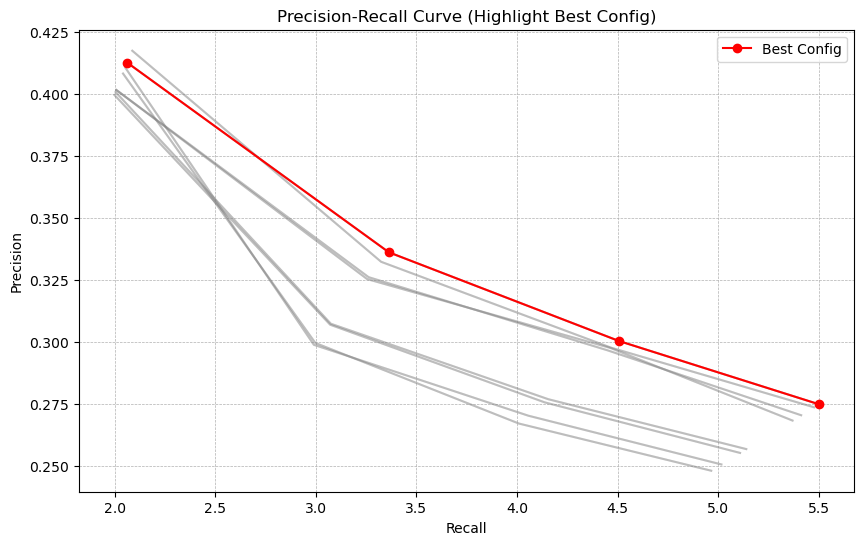

In [66]:
plt.figure(figsize=(10,6))
for res in results:
    plt.plot(res['recall'], res['precision'], color='gray', alpha=0.3)  # faint
plt.plot(best_scores[1], best_scores[0], marker='o', linestyle='-', color='red', label="Best Config")  # highlight
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Highlight Best Config)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [67]:
import os
import joblib
import pickle

# Save directory
local_dir = "./Pickle"
os.makedirs(local_dir, exist_ok=True)

# Save TF-IDF Vectorizer
joblib.dump(tfidf, os.path.join(local_dir, "content_tfidf_vectorizer.pkl"))

# Save cosine similarity matrix
with open(os.path.join(local_dir, "content_cosine_sim_matrix.pkl"), "wb") as f:
    pickle.dump(best_cosine_sim, f)

# Save book indices mapping
with open(os.path.join(local_dir, "content_book_indices.pkl"), "wb") as f:
    pickle.dump(name_to_indices, f)

# Save best configuration
with open(os.path.join(local_dir, "content_best_config.pkl"), "wb") as f:
    pickle.dump(best_config, f)

print("✅ Best model and config saved successfully for deployment!")

✅ Best model and config saved successfully for deployment!
